In [197]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, log_loss,confusion_matrix,f1_score
from sklearn.preprocessing import LabelEncoder
from pymongo import MongoClient
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib


In [25]:
import re
import nltk
from nltk.util import pr
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/gass/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    words = [stemmer.stem(word) for word in text.split() if word not in stopword]
    return " ".join(words)
     

In [43]:
df = pd.read_csv("Approach_to_Social_Media_Cyberbullying_and_Harassment_Detection_Using_Advanced_Machine_Learning.csv")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    8452 non-null   object
 1   Label   8450 non-null   object
 2   Types   4825 non-null   object
dtypes: object(3)
memory usage: 198.2+ KB


In [45]:
df['Label'].unique()


array(['Not-Bullying', 'Bullying', 'Not - Bullying', 'Bullying ',
       'Not Bullying ', 'Not- Bullying ', 'Not -Bullying',
       'Not-Bullying ', 'Not -Bullying ', 'Not bullying ', 'Bullying.',
       'Not-Bulyying', 'Not-Bulllying', 'Bullyiing', 'Not-Bulying',
       'Not- Bullying', 'Bullyibg', 'Bullying  ', nan, 'Bullyinfg'],
      dtype=object)

In [47]:
df[df['Types'].isna()]


,Text,Label,Types
0,Ten outside soon doctor shake everyone treatme...,Not-Bullying,NaN
1,my life has come to a standstill and at this p...,Not-Bullying,NaN
4,"Oh hey, you should be ashamed of your disgusti...",Not - Bullying,NaN
9,Wishing my arena partner was on.,Not Bullying,NaN
10,"I hope this round humbled the girls, they can'...",Not- Bullying,NaN
...,...,...,...
8433,"Why does god require you to defend Islam, kill...",Not-Bullying,NaN
8434,I appreciate you revealing your true identity ...,Not-Bullying,NaN
8435,Donald Trump's position on radical Islamic ter...,Not-Bullying,NaN
8436,The terrorists do not speak for Islam; instead...,Not-Bullying,NaN


In [49]:
df.dropna(subset=["Label"])


,Text,Label,Types
0,Ten outside soon doctor shake everyone treatme...,Not-Bullying,NaN
1,my life has come to a standstill and at this p...,Not-Bullying,NaN
2,girl this nigga make me sick to my stomach,Bullying,Ethnicity
3,I wanna fuck you,Bullying,Sexual
4,"Oh hey, you should be ashamed of your disgusti...",Not - Bullying,NaN
...,...,...,...
8447,Please help this Christian nationalist battle ...,Bullying,Vocational
8448,Has the Holy Quran ever been read by the membe...,Bullying,Sexual
8449,And that is the difficulty - you need basic gu...,Bullying,Religion
8450,"As they will only encounter Muslim women, help...",Bullying,Religion


In [53]:
df['Label'] = df[['Label']].fillna(value="NB")

In [55]:
df.loc[df["Label"].str.startswith("N"),"Label"] = "NB"
df.loc[df["Label"].str.startswith("B"),"Label"] = "B"
df.head()

,Text,Label,Types
0,Ten outside soon doctor shake everyone treatme...,NB,NaN
1,my life has come to a standstill and at this p...,NB,NaN
2,girl this nigga make me sick to my stomach,B,Ethnicity
3,I wanna fuck you,B,Sexual
4,"Oh hey, you should be ashamed of your disgusti...",NB,NaN


In [65]:
df['Types'].unique()


array(['unknown', 'ethnicity', 'sexual', 'religion', 'threats', 'troll',
       'vocational', 'political', 'religious', 'threat', 'racism',
       'vocation', 'saxual', 'religon', 'ethnically'], dtype=object)

In [59]:
df['Types'] = df[['Types']].fillna(value="Unknown")


In [61]:
df.isna().count()


Text     8452
Label    8452
Types    8452
dtype: int64

In [63]:
df['Types'] = df['Types'].apply(lambda s:s.lower().strip())


In [67]:
df['Types'] = df['Types'].str.strip().str.replace("religon", "religion")


In [69]:
df['Types'].unique()


array(['unknown', 'ethnicity', 'sexual', 'religion', 'threats', 'troll',
       'vocational', 'political', 'religious', 'threat', 'racism',
       'vocation', 'saxual', 'ethnically'], dtype=object)

In [71]:
d = {"e":"ethnicity","r":"religion","s":"sexual","v":"vocational",'th':"threat",'tr':"troll"}
df['Types'] = df['Types'].apply(lambda s:d.get(s[0],0) or d.get(s[:2],"unknown"))
df["Types"].unique()

array(['unknown', 'ethnicity', 'sexual', 'religion', 'threat', 'troll',
       'vocational'], dtype=object)

In [204]:
#label encoding
from sklearn.preprocessing import LabelEncoder
types_le = LabelEncoder()
df['le_type'] = types_le.fit_transform(df['Types'])
df.tail()
types_le.fit(df['Types']) 
# Save it to a file
joblib.dump(types_le, "types_le.pkl")

['types_le.pkl']

In [77]:
pd.get_dummies(df['Label'])

,B,NB
0,False,True
1,False,True
2,True,False
3,True,False
4,False,True
...,...,...
8447,True,False
8448,True,False
8449,True,False
8450,True,False


In [83]:
df['label_num'] = df['Label'].map({'NB': 0, 'B': 1})

In [79]:
df['Text'] = df['Text'].str.lower()

In [85]:
df.head()

,Text,Label,Types,le_type,label_num
0,ten outside soon doctor shake everyone treatme...,NB,unknown,5,0
1,my life has come to a standstill and at this p...,NB,unknown,5,0
2,girl this nigga make me sick to my stomach,B,ethnicity,0,1
3,i wanna fuck you,B,sexual,2,1
4,"oh hey, you should be ashamed of your disgusti...",NB,unknown,5,0


In [91]:
# ---------------- MONGODB ----------------
MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "Cyberbullying"
COLLECTION_NAME = "cyberbullying"
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

In [93]:
data = df.to_dict('records')
data

[{'Text': 'ten outside soon doctor shake everyone treatment seat radio land. ',
  'Label': 'NB',
  'Types': 'unknown',
  'le_type': 5,
  'label_num': 0},
 {'Text': 'my life has come to a standstill and at this point.',
  'Label': 'NB',
  'Types': 'unknown',
  'le_type': 5,
  'label_num': 0},
 {'Text': 'girl this nigga make me sick to my stomach',
  'Label': 'B',
  'Types': 'ethnicity',
  'le_type': 0,
  'label_num': 1},
 {'Text': 'i wanna fuck you',
  'Label': 'B',
  'Types': 'sexual',
  'le_type': 2,
  'label_num': 1},
 {'Text': 'oh hey, you should be ashamed of your disgusting self',
  'Label': 'NB',
  'Types': 'unknown',
  'le_type': 5,
  'label_num': 0},
 {'Text': "haha isn't route running part of the position? people are dumb. but fuck edelman! he just looks like he says",
  'Label': 'B',
  'Types': 'ethnicity',
  'le_type': 0,
  'label_num': 1},
 {'Text': 'racism is when u select yur white clothes to wash first before the black and colored ones',
  'Label': 'B',
  'Types': 'ethni

In [95]:
collection.insert_many(data)

NameError: name 'url' is not defined

**Descriptive analysis**

In [100]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       8452 non-null   object
 1   Label      8452 non-null   object
 2   Types      8452 non-null   object
 3   le_type    8452 non-null   int64 
 4   label_num  8452 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 330.3+ KB


,Text,Label,Types,le_type,label_num
count,8452,8452,8452,8452.000000,8452.000000
unique,5978,2,7,NaN,NaN
top,the police have to take any terrorist,B,unknown,NaN,NaN
freq,15,4834,4384,NaN,NaN
mean,NaN,NaN,NaN,4.044723,0.571936
std,NaN,NaN,NaN,1.609385,0.494827
min,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,0.000000
50%,NaN,NaN,NaN,5.000000,1.000000
75%,NaN,NaN,NaN,5.000000,1.000000


In [104]:
df['Label'].value_counts()


Label
B     4834
NB    3618
Name: count, dtype: int64

In [106]:
df['Label'].value_counts(normalize=True) * 100


Label
B     57.193564
NB    42.806436
Name: proportion, dtype: float64

In [110]:
df['label_num'].value_counts()


label_num
1    4834
0    3618
Name: count, dtype: int64

In [112]:
df['le_type'].value_counts()


le_type
5    4384
2    1031
4     955
1     756
6     751
3     374
0     201
Name: count, dtype: int64

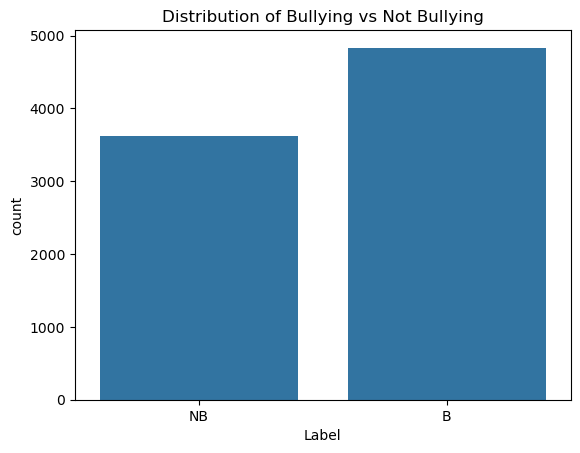

In [118]:

sns.countplot(data=df, x='Label')
plt.title("Distribution of Bullying vs Not Bullying")
plt.show()


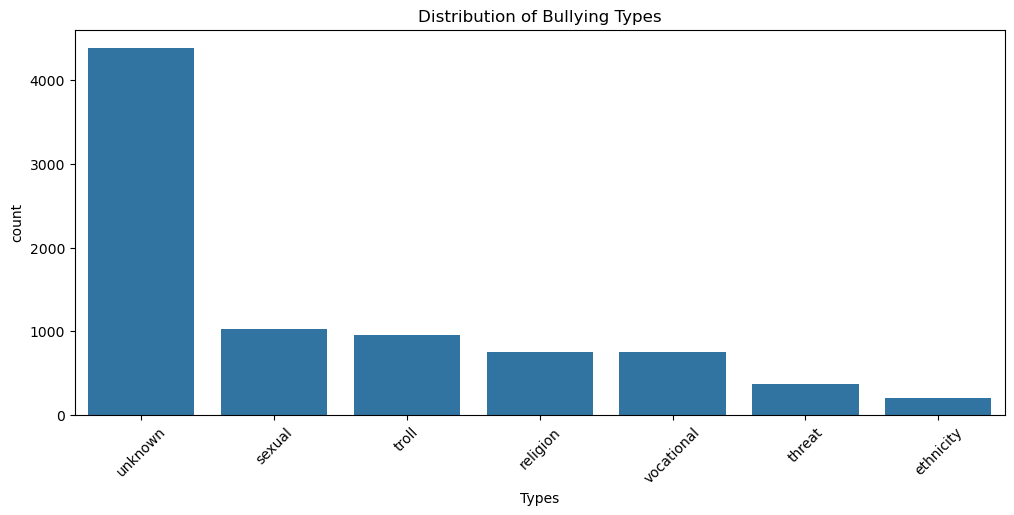

In [120]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='Types', order=df['Types'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Bullying Types")
plt.show()


In [122]:
df_copy=df
df_copy

,Text,Label,Types,le_type,label_num
0,ten outside soon doctor shake everyone treatme...,NB,unknown,5,0
1,my life has come to a standstill and at this p...,NB,unknown,5,0
2,girl this nigga make me sick to my stomach,B,ethnicity,0,1
3,i wanna fuck you,B,sexual,2,1
4,"oh hey, you should be ashamed of your disgusti...",NB,unknown,5,0
...,...,...,...,...,...
8447,please help this christian nationalist battle ...,B,vocational,6,1
8448,has the holy quran ever been read by the membe...,B,sexual,2,1
8449,and that is the difficulty - you need basic gu...,B,religion,1,1
8450,"as they will only encounter muslim women, help...",B,religion,1,1


In [126]:
df_copy['Text']=df_copy['Text'].apply(clean_text)
df_copy

,Text,Label,Types,le_type,label_num
0,ten outsid soon doctor shake everyon treatment...,NB,unknown,5,0
1,life come standstil point,NB,unknown,5,0
2,girl nigga make sick stomach,B,ethnicity,0,1
3,wanna fuck,B,sexual,2,1
4,oh hey asham disgust self,NB,unknown,5,0
...,...,...,...,...,...
8447,pleas help christian nationalist battl radic i...,B,vocational,6,1
8448,holi quran ever read member isi muslim terrori...,B,sexual,2,1
8449,difficulti need basic guidelin get peopl compr...,B,religion,1,1
8450,encount muslim women help muslim male avoid fitna,B,religion,1,1


**Building Modele**

In [139]:
X = df_copy['Text']
y_label = df_copy['label_num']   # bullying or not
y_type = df_copy['le_type']    # type of bullying

In [143]:
#--------- split for label prediction
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
    X, y_label, test_size=0.2, random_state=42, stratify=y_label
)

#----------split for type prediction
bullying_df = df_copy[df_copy['label_num'] == 1]
X_type = bullying_df['Text']
y_type_filtered = bullying_df['le_type']

X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(
    X_type, y_type_filtered, test_size=0.2, random_state=42, stratify=y_type_filtered
)

In [156]:
#---predict label

#logistic regression
model_label_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=300))
])

model_label_lr.fit(X_train_label, y_train_label)

y_train_pred_lr = model_label_lr.predict(X_train_label)

y_pred_label_lr = model_label_lr.predict(X_test_label)

f1_train_lr = f1_score(y_train_label, y_train_pred_lr)
f1_test_lr = f1_score(y_test_label, y_pred_label_lr)

print("Logistic Regression - Binary Label Report:\n")
print(classification_report(y_test_label, y_pred_label_lr))


f1_train_lr = f1_score(y_train_label, y_train_pred_lr)
f1_test_lr = f1_score(y_test_label, y_pred_label_lr)

print("Stage 1 - Logistic Regression (Binary Label)")
print("F1 score - Train:", round(f1_train_lr, 4))
print("F1 score - Test :", round(f1_test_lr, 4))
print("F1 Gap (Train - Test):", round(f1_train_lr - f1_test_lr, 4))


#random forest
model_label_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

model_label_rf.fit(X_train_label, y_train_label)

y_pred_label_rf = model_label_rf.predict(X_test_label)
y_train_pred_rf = model_label_rf.predict(X_train_label)

print("Random Forest - Binary Label Report:\n")
print(classification_report(y_test_label, y_pred_label_rf))

f1_train_rf = f1_score(y_train_label, y_train_pred_rf)
f1_test_rf = f1_score(y_test_label, y_pred_label_rf)

print("\nStage 1 - Random Forest (Binary Label)")
print("F1 score - Train:", round(f1_train_rf, 4))
print("F1 score - Test :", round(f1_test_rf, 4))
print("F1 Gap (Train - Test):", round(f1_train_rf - f1_test_rf, 4))

Logistic Regression - Binary Label Report:

              precision    recall  f1-score   support

           0       0.91      0.84      0.88       724
           1       0.89      0.94      0.91       967

    accuracy                           0.90      1691
   macro avg       0.90      0.89      0.90      1691
weighted avg       0.90      0.90      0.90      1691

Stage 1 - Logistic Regression (Binary Label)
F1 score - Train: 0.9471
F1 score - Test : 0.914
F1 Gap (Train - Test): 0.033
Random Forest - Binary Label Report:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       724
           1       0.91      0.90      0.91       967

    accuracy                           0.90      1691
   macro avg       0.89      0.90      0.90      1691
weighted avg       0.90      0.90      0.90      1691


Stage 1 - Random Forest (Binary Label)
F1 score - Train: 0.9841
F1 score - Test : 0.9096
F1 Gap (Train - Test): 0.0745


In [158]:
#--predict type

#logistic regression
model_type_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=300, multi_class='multinomial'))
])

model_type_lr.fit(X_train_type, y_train_type)

y_pred_type_lr = model_type_lr.predict(X_test_type)
y_train_pred_type_lr = model_type_lr.predict(X_train_type)


print("Logistic Regression - Bullying Type Report:\n")
print(classification_report(y_test_type, y_pred_type_lr))
f1_train_type_lr = f1_score(y_train_type, y_train_pred_type_lr, average='weighted')
f1_test_type_lr = f1_score(y_test_type, y_pred_type_lr, average='weighted')

print("\nStage 2 - Logistic Regression (Bullying Type)")
print("F1 score - Train:", round(f1_train_type_lr, 4))
print("F1 score - Test :", round(f1_test_type_lr, 4))
print("F1 Gap (Train - Test):", round(f1_train_type_lr - f1_test_type_lr, 4))


#random forest

model_type_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

model_type_rf.fit(X_train_type, y_train_type)

y_pred_type_rf = model_type_rf.predict(X_test_type)
y_train_pred_type_rf = model_type_rf.predict(X_train_type)

print("Random Forest - Bullying Type Report:\n")
print(classification_report(y_test_type, y_pred_type_rf))
f1_train_type_rf = f1_score(y_train_type, y_train_pred_type_rf, average='weighted')
f1_test_type_rf = f1_score(y_test_type, y_pred_type_rf, average='weighted')

print("\nStage 2 - Random Forest (Bullying Type)")
print("F1 score - Train:", round(f1_train_type_rf, 4))
print("F1 score - Test :", round(f1_test_type_rf, 4))
print("F1 Gap (Train - Test):", round(f1_train_type_rf - f1_test_type_rf, 4))

Logistic Regression - Bullying Type Report:

              precision    recall  f1-score   support

           0       0.92      0.60      0.73        40
           1       0.95      0.97      0.96       150
           2       0.76      0.90      0.83       206
           3       0.85      0.53      0.65        74
           4       0.87      0.93      0.90       191
           5       0.96      0.92      0.94       157
           6       0.75      0.72      0.73       149

    accuracy                           0.85       967
   macro avg       0.87      0.80      0.82       967
weighted avg       0.86      0.85      0.85       967


Stage 2 - Logistic Regression (Bullying Type)
F1 score - Train: 0.9113
F1 score - Test : 0.8482
F1 Gap (Train - Test): 0.0631
Random Forest - Bullying Type Report:

              precision    recall  f1-score   support

           0       0.75      0.68      0.71        40
           1       0.97      0.95      0.96       150
           2       0.83      

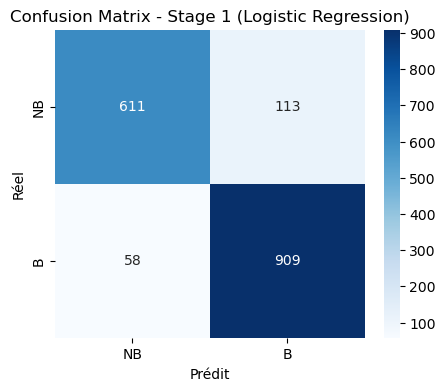

In [166]:


# Exemple pour Stage 1 - Logistic Regression
cm = confusion_matrix(y_test_label, y_pred_label_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NB','B'], yticklabels=['NB','B'])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Confusion Matrix - Stage 1 (Logistic Regression)")
plt.show()


/tmp/ipykernel_24362/717484143.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='feature', data=coef_df.head(20), palette='Reds_r')


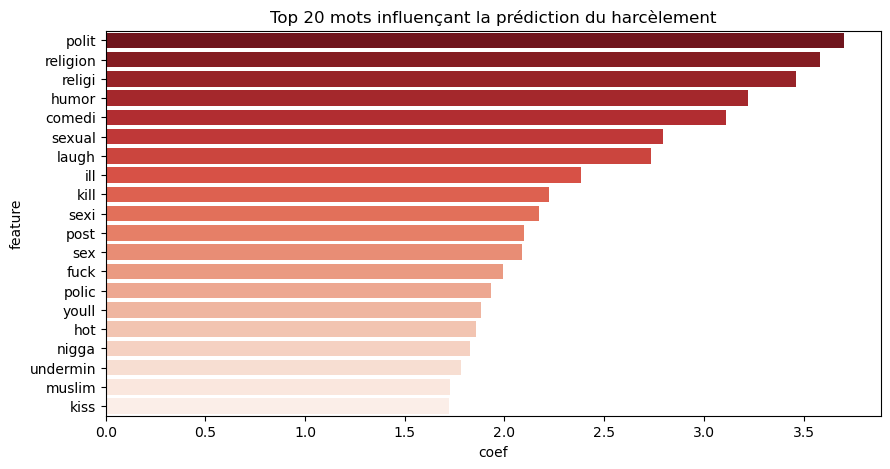

In [168]:
# Obtenir les coefficients du modèle
feature_names = model_label_lr.named_steps['tfidf'].get_feature_names_out()
coefficients = model_label_lr.named_steps['clf'].coef_[0]

# Créer DataFrame
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefficients})
coef_df = coef_df.sort_values(by='coef', ascending=False)

# Top 20 mots associés au harcèlement
plt.figure(figsize=(10,5))
sns.barplot(x='coef', y='feature', data=coef_df.head(20), palette='Reds_r')
plt.title("Top 20 mots influençant la prédiction du harcèlement")
plt.show()


In [170]:
def predict_text(text, model_label, model_type, le_type_mapping=None):
    """
    text: string, input message
    model_label: Stage 1 model (binary)
    model_type: Stage 2 model (multi-class)
    le_type_mapping: optional dict to map le_type numbers to strings
    """
    # Stage 1: predict bullying or not
    label_pred = model_label.predict([text])[0]
    label_str = "Bullying" if label_pred == 1 else "Not-Bullying"
    
    print(f"Stage 1 Prediction: {label_str} (label_num={label_pred})")
    
    # Stage 2: predict type only if bullying
    if label_pred == 1:
        type_pred = model_type.predict([text])[0]
        if le_type_mapping:
            type_pred_str = le_type_mapping[type_pred]
        else:
            type_pred_str = str(type_pred)
        print(f"Stage 2 Prediction: {type_pred_str} (le_type={type_pred})")
    else:
        print("Stage 2 Prediction: N/A (not bullying)")


In [195]:
le_type_mapping = dict(zip(df['le_type'], df['Types']))

test_text = "Son of a bitch!"

predict_text(test_text, model_label_lr, model_type_lr, le_type_mapping)


Stage 1 Prediction: Bullying (label_num=1)
Stage 2 Prediction: sexual (le_type=2)


In [199]:
# Stage 1: Binary label prediction
joblib.dump(model_label_lr, "model_label_lr.pkl")  # Logistic Regression
joblib.dump(model_label_rf, "model_label_rf.pkl")  # Random Forest (optional)

# Stage 2: Multi-class type prediction
joblib.dump(model_type_lr, "model_type_lr.pkl")    # Logistic Regression
joblib.dump(model_type_rf, "model_type_rf.pkl")    # Random Forest (optional)

['model_type_rf.pkl']

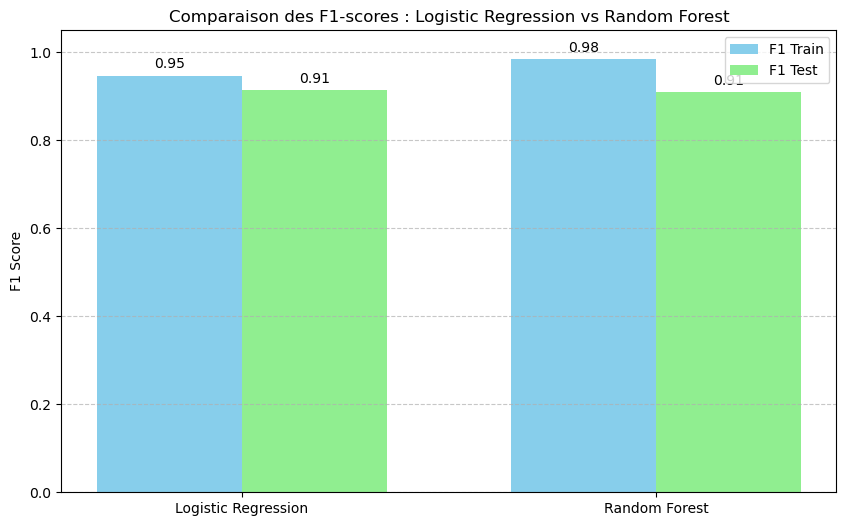

/tmp/ipykernel_24362/1107248909.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_gap, palette='magma')


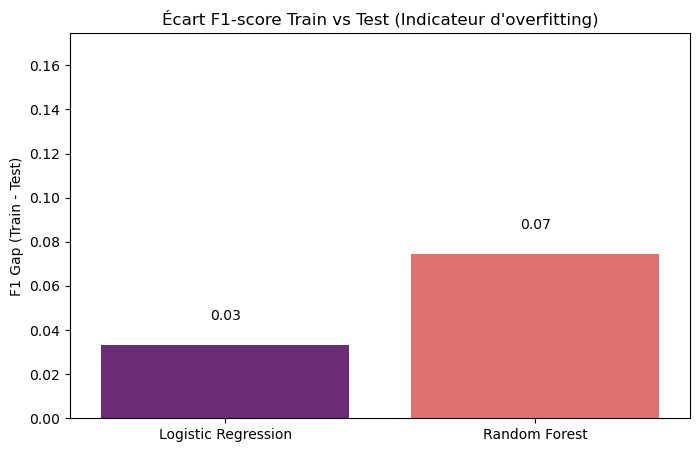

In [208]:


# Données
models = ['Logistic Regression', 'Random Forest']
f1_train = [f1_train_lr, f1_train_rf]
f1_test  = [f1_test_lr, f1_test_rf]
f1_gap   = [f1_train_lr - f1_test_lr, f1_train_rf - f1_test_rf]

# Figure
plt.figure(figsize=(10,6))

# Bar plot pour Train et Test F1
bar_width = 0.35
x = range(len(models))

plt.bar(x, f1_train, width=bar_width, label='F1 Train', color='skyblue')
plt.bar([i + bar_width for i in x], f1_test, width=bar_width, label='F1 Test', color='lightgreen')

# Ajouter valeurs au-dessus des barres
for i in x:
    plt.text(i, f1_train[i]+0.01, f"{f1_train[i]:.2f}", ha='center', va='bottom')
    plt.text(i + bar_width, f1_test[i]+0.01, f"{f1_test[i]:.2f}", ha='center', va='bottom')

plt.xticks([i + bar_width/2 for i in x], models)
plt.ylabel("F1 Score")
plt.title("Comparaison des F1-scores : Logistic Regression vs Random Forest")
plt.ylim(0,1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar plot pour le Gap F1 (Overfitting)
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=f1_gap, palette='magma')
plt.ylabel("F1 Gap (Train - Test)")
plt.title("Écart F1-score Train vs Test (Indicateur d'overfitting)")
for i, gap in enumerate(f1_gap):
    plt.text(i, gap+0.01, f"{gap:.2f}", ha='center', va='bottom')
plt.ylim(0, max(f1_gap)+0.1)
plt.show()
